In [28]:
import influxdb_client
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)


with open("C:\\Users\\Ye Lab\\Desktop\\labrad_tools\\log\\secrets.json", "r") as f:
    secrets = json.load(f)

token = secrets["INFLUXDB_TOKEN"]
url = secrets["INFLUXDB_URL"]

In [17]:

client = influxdb_client.InfluxDBClient(token=token, url=url, org="krb", database="log")
queries = [
    'from(bucket: "log") |> range(start: -7d) |> filter(fn: (r) => r._measurement == "wavemeter" and r._field == "freq" and r.laser == "Rb Repump")',
    'from(bucket: "log") |> range(start: -7d) |> filter(fn: (r) => r._measurement == "bmp390" and r._field == "value" and r.channel == "pressure")',
    'from(bucket: "log") |> range(start: -7d) |> filter(fn: (r) => r._measurement == "temperature" and r._field == "temp" and r.sensor == "x1B20 Room")',
    'from(bucket: "log") |> range(start: -7d) |> filter(fn: (r) => r._measurement == "temperature" and r._field == "humidity" and r.sensor == "x1B20 Room")',
]

dfs = []
for query in queries:
    result = client.query_api().query_data_frame(query)
    dfs.append(result)

In [25]:
laser_df = dfs[0].drop(columns=["_start", "_stop", "_measurement", "_field", "laser", "result", "table"])
laser_df["Sensor"] = "Rb Repump"
pressure_df = dfs[1].drop(columns=["_start", "_stop", "_measurement", "_field", "channel", "result", "table"])
pressure_df["Sensor"] = "BMP390 Pressure"
temp_df = dfs[2].drop(columns=["_start", "_stop", "_measurement", "_field", "sensor", "result", "table"])
temp_df["Sensor"] = "x1B20 Room Temperature"
hum_df = dfs[3].drop(columns=["_start", "_stop", "_measurement", "_field", "sensor", "result", "table"])
hum_df["Sensor"] = "x1B20 Room Humidity"

df = pd.concat([laser_df, pressure_df, temp_df, hum_df])
df = df.pivot(index="_time", columns="Sensor", values="_value")
df.dropna(inplace=True)

array([<Axes: xlabel='_time'>, <Axes: xlabel='_time'>,
       <Axes: xlabel='_time'>, <Axes: xlabel='_time'>], dtype=object)

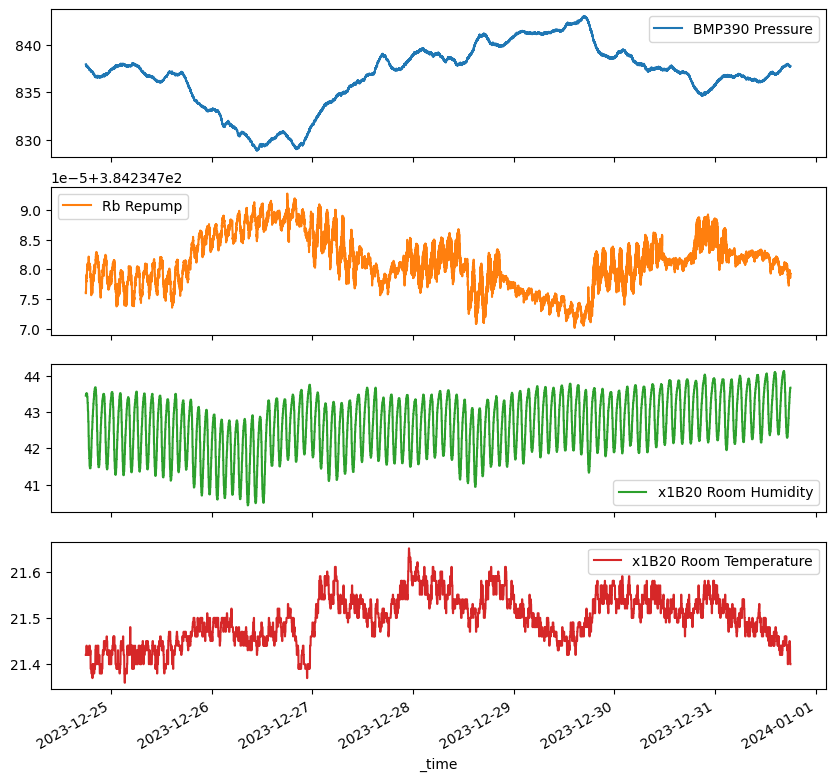

In [27]:
df.plot(subplots=True, figsize=(10, 10))

In [32]:
df

Sensor,BMP390 Pressure,Rb Repump,x1B20 Room Humidity,x1B20 Room Temperature
_time,,,,
2023-12-24 18:00:31+00:00,837.902023,384.234776,43.45,21.42
2023-12-24 18:01:31+00:00,837.857422,384.234776,43.45,21.42
2023-12-24 18:02:31+00:00,837.826328,384.234776,43.45,21.42
2023-12-24 18:03:31+00:00,837.841169,384.234777,43.45,21.42
2023-12-24 18:04:31+00:00,837.910078,384.234777,43.51,21.42
...,...,...,...,...
2023-12-31 17:55:40+00:00,837.704833,384.234779,43.67,21.40
2023-12-31 17:56:40+00:00,837.760207,384.234779,43.67,21.40
2023-12-31 17:57:40+00:00,837.681874,384.234779,43.67,21.40


[ 3.84235138e+02  3.14752446e-05  6.62907755e-07 -1.26936032e-06]
Standard deviation of residuals: 1.70 MHz
Standard deviation of frequency: 4.17 MHz


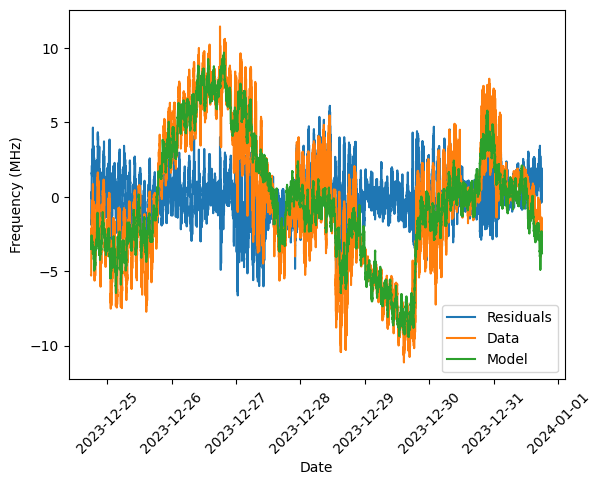

In [47]:
# fit the Rb repump frequency to a linear combination of the temperature, humidity, and pressure
def func(x, a, b, c, d):
    return a + b*x[:, 0] + c*x[:, 1] + d*x[:, 2]

x = df[["x1B20 Room Temperature", "x1B20 Room Humidity", "BMP390 Pressure"]].values
y = df["Rb Repump"].values
popt, pcov = curve_fit(func, x, y)
print(popt)

# plot the residuals as a function of time
plt.figure()
plt.plot(df.index, (y - func(x, *popt)) * 1e6, label="Residuals")
plt.xlabel("Date")
plt.ylabel("Frequency (MHz)")
plt.xticks(rotation=45)

plt.plot(df.index, y * 1e6 - np.mean(y) * 1e6, label="Data")
plt.plot(df.index, func(x, *popt) * 1e6 - np.mean(func(x, *popt)) * 1e6, label="Model")
plt.legend()

print("Standard deviation of residuals: {:.2f} MHz".format(np.std(y - func(x, *popt)) * 1e6))
print("Standard deviation of frequency: {:.2f} MHz".format(np.std(y) * 1e6))